In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [4]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

In [5]:
import numpy as np
import seaborn as sns
import os
import math
import pickle

In [6]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, ConcatDataset

In [7]:
from moe_models import cross_entropy_loss
from moe_expectation_model import moe_expectation_model

device cpu
device cpu


In [8]:
dataset = 'fmnist_mnist_10000_3x3'
model_path = 'results/fmnist'
fig_path = 'figures/fmnist'

In [9]:
#transform = tv.transforms.Compose()
fmnist_trainset = tv.datasets.FashionMNIST('data', transform=tv.transforms.ToTensor(), train=True)
fmnist_trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
fmnist_testset = tv.datasets.FashionMNIST('data',transform=tv.transforms.ToTensor(), train=False)
fmnist_testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
#transform = tv.transforms.Compose()
mnist_trainset = tv.datasets.MNIST('data', transform=tv.transforms.ToTensor(), train=True)
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
mnist_testset = tv.datasets.MNIST('data',transform=tv.transforms.ToTensor(), train=False)
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [13]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

In [14]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18), classes=10, classnames=None):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = nrows * ncols
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()

    for i in range(n_images):
        ax[i].imshow( images_to_plot[i,:,:,:]) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[i].axis('off')  
        if titles is not None and i<classes:
            ax[i].set_title(titles[i%classes])
    

In [44]:
batchsize=125
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=True, num_workers=1, pin_memory=True)


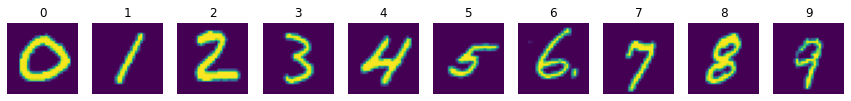

In [14]:
# Display 10 samples from each of the 10 classes in Fashion Mnist dataset

images_to_plot = None
i = 0
for data , labels in trainloader:
    #print(data.shape)
    index = np.where(labels==i)[0]
    if len(index) >= 10:
        if i == 0:
            images_to_plot = data[index[0:10],:,:]
        else:
            images_to_plot = np.vstack((images_to_plot, data[index[0:10],:,:]))
        i += 1
images_to_plot = images_to_plot.reshape(10,10,28, 28, 1).transpose(1,0,2,3,4).reshape(100,28,28,1)
plot_colour_images(images_to_plot, nrows=1, ncols=10,thefigsize=(15,15), titles=classes_mnist)
plt.savefig(os.path.join('figures/review', 'mnist_transfer_images.png'))

In [15]:
def filter_classes(classes_sub, classes_full, size, data):
    start = 0
    labels = data.targets
    index = []
    per_class_size = math.ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index

In [16]:
palette = [plt.get_cmap('tab20')(i) for i in range(20)]
palette.pop(6)
palette.pop(6)

(1.0, 0.596078431372549, 0.5882352941176471, 1.0)

In [17]:
def colors(p,  palette=['y','g','r','c','b','tab:pink']):
    uniq_y = np.unique(p)
    pred_color = [palette[i] for i in uniq_y]
    return pred_color

In [18]:
def pca_tsne_plot(X, y, classes, dataset, size, filter_class=False):
    transformer = IncrementalPCA(n_components=50, batch_size=128)
    if filter_class:
        index = filter_classes(classes_sub, size)
    else:
        index = list(range(0,size))
    X_pca = transformer.fit_transform(X.reshape(X.shape[0],X.shape[-1]*X.shape[-1]))
    X_pca = X_pca[index]
    print('X:',X.shape)
    y = y[index]
    print(np.unique(y, return_counts=True))
    print('PCA:',X_pca.shape)
    print('y:', y.shape)
    X_embedded = TSNE(n_components=2,perplexity=50.0,).fit_transform(X_pca)
    print('TSNE:',X_embedded.shape)    
    fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))
    true_label_names = [classes[i] for i in y]
    true_color = colors(y, palette[0:len(classes)]) 
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=true_label_names, hue_order=classes, palette=true_color, ax=ax)
    plt.savefig(os.path.join('figures/fmnist', dataset+'.png'))
    return X_pca, X_embedded
    

In [16]:
#Expert network
class expert_layers(nn.Module):
    def __init__(self, output):
        super(expert_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=6*12*12, out_features=60)
        self.fc2 = nn.Linear(in_features=60, out_features=120)

        self.out = nn.Linear(in_features=120, out_features=output)


    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 6*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t


In [19]:
#Expert network
class expert_layers(nn.Module):
    def __init__(self, output):
        super(expert_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        
#         self.fc1 = nn.Linear(in_features=1*12*12, out_features=5)
#         self.fc2 = nn.Linear(in_features=5, out_features=10)

        self.out = nn.Linear(in_features=1*13*13, out_features=output)


    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 1*13*13)
#         t = self.fc1(t)
#         t = F.relu(t)

        # fc2
#         t = self.fc2(t)
#         t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t


In [20]:
#Expert network
class expert_layers_presoftmax(nn.Module):
    def __init__(self, output):
        super(expert_layers_presoftmax, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=6*12*12, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)

        self.out = nn.Linear(in_features=60, out_features=output)


    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 6*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        
        return t


In [20]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [57]:
#Expert network
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=num_experts)
        self.num_experts = num_experts
        self.count = 0

    def forward(self, t, T=1.0):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t, dim=1)
        return t


In [21]:
#Expert network
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

#         self.fc1 = nn.Linear(in_features=1*12*12, out_features=5)
#         self.fc2 = nn.Linear(in_features=5, out_features=10)
        self.out = nn.Linear(in_features=1*13*13, out_features=num_experts)
        self.num_experts = num_experts
        self.count = 0

    def forward(self, t,T=1.0):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 1*13*13)
#         t = self.fc1(t)
#         t = F.relu(t)

        # fc2
#         t = self.fc2(t)
#         t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t, dim=1)
        return t


In [22]:
# compute
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [23]:
batchsize = 125

In [24]:
total_experts = 10

In [25]:
num_classes = 10

In [26]:
num_epochs = 20

In [27]:
fmnist_indices_train = filter_classes(classes_fmnist[0:5], classes_fmnist, 5000, fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:5], classes_fmnist, 1500, fmnist_testset)
print(len(fmnist_indices_train))

5000


In [28]:
mnist_indices_train = filter_classes(classes_mnist[5:], classes_mnist, 5000, mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[5:], classes_mnist, 1500, mnist_testset)
print(len(mnist_indices_train))

5000


In [29]:
trainset = ConcatDataset([Subset(fmnist_trainset,fmnist_indices_train), 
                         Subset(mnist_trainset,mnist_indices_train)])
testset = ConcatDataset([Subset(fmnist_testset,fmnist_indices_test), 
                        Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)

In [24]:
fmnist_trainloader = torch.utils.data.DataLoader(Subset(fmnist_trainset, fmnist_indices_train), 
                                          batch_size=batchsize,
                                          shuffle=True, num_workers=1)

fmnist_testloader = torch.utils.data.DataLoader(Subset(fmnist_testset, fmnist_indices_test),
                                         batch_size=len(fmnist_testset),
                                         shuffle=True, num_workers=1)
print(len(fmnist_trainloader.dataset))
print(len(fmnist_testloader.dataset))

5000
1500


In [30]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [31]:
# experiment with models with different number of experts
w_importance=0.0
w_ortho = 0.0
w_ideal_gate = 0.0

augment = False
attention = False
T_max = 1
#T_decay = T_max/num_epochs
#T_decay = T_max/(num_epochs - T_decay_start)
T_decay = 0
T_decay_start = 0
T=T_max

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if T_decay > 0:
        plot_file += '_Tdecay_'+str(T_decay)
    if T_decay_start > 0:
        plot_file += '_Tdecaystart_'+str(T_decay_start)
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    if augment:
        plot_file += '_augment'
    if attention:
        plot_file += '_attention'
    plot_file += '_'+specific
    
    return plot_file


In [32]:
# experiment with models with different number of experts
models = {#'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss,'experts':{}}, 
          'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}}, 
#           'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}}
         }
for key, val in models.items():
    print('Model:', key)
    for num_experts in range(total_experts, total_experts+1):
        print('Number of experts ', num_experts)
        if 'pre_softmax' in key:
            expert_models = experts(num_experts, num_classes, expert_layers_presoftmax)
        else:
            expert_models = experts(num_experts, num_classes)
        gate_model = gate_layers(num_experts)
        moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
        plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
        torch.save(models,open(os.path.join(model_path, plot_file),'wb'))

Model: moe_expectation_model
Number of experts  10
model params: 18810
epoch 0 training loss 0.63 , training accuracy 0.81 , test accuracy 0.84
epoch 1 training loss 0.33 , training accuracy 0.89 , test accuracy 0.86
epoch 2 training loss 0.29 , training accuracy 0.90 , test accuracy 0.87
epoch 3 training loss 0.27 , training accuracy 0.91 , test accuracy 0.87
epoch 4 training loss 0.25 , training accuracy 0.91 , test accuracy 0.87
epoch 5 training loss 0.23 , training accuracy 0.92 , test accuracy 0.88
epoch 6 training loss 0.22 , training accuracy 0.92 , test accuracy 0.88
epoch 7 training loss 0.21 , training accuracy 0.92 , test accuracy 0.89
epoch 8 training loss 0.20 , training accuracy 0.93 , test accuracy 0.88
epoch 9 training loss 0.20 , training accuracy 0.93 , test accuracy 0.88
epoch 10 training loss 0.19 , training accuracy 0.93 , test accuracy 0.89
epoch 11 training loss 0.19 , training accuracy 0.93 , test accuracy 0.88
epoch 12 training loss 0.18 , training accuracy 0.9

In [33]:
plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
models = torch.load(os.path.join(model_path, plot_file))

model:  fmnist_mnist_10000_3x3_T_1_10_10_model.pt


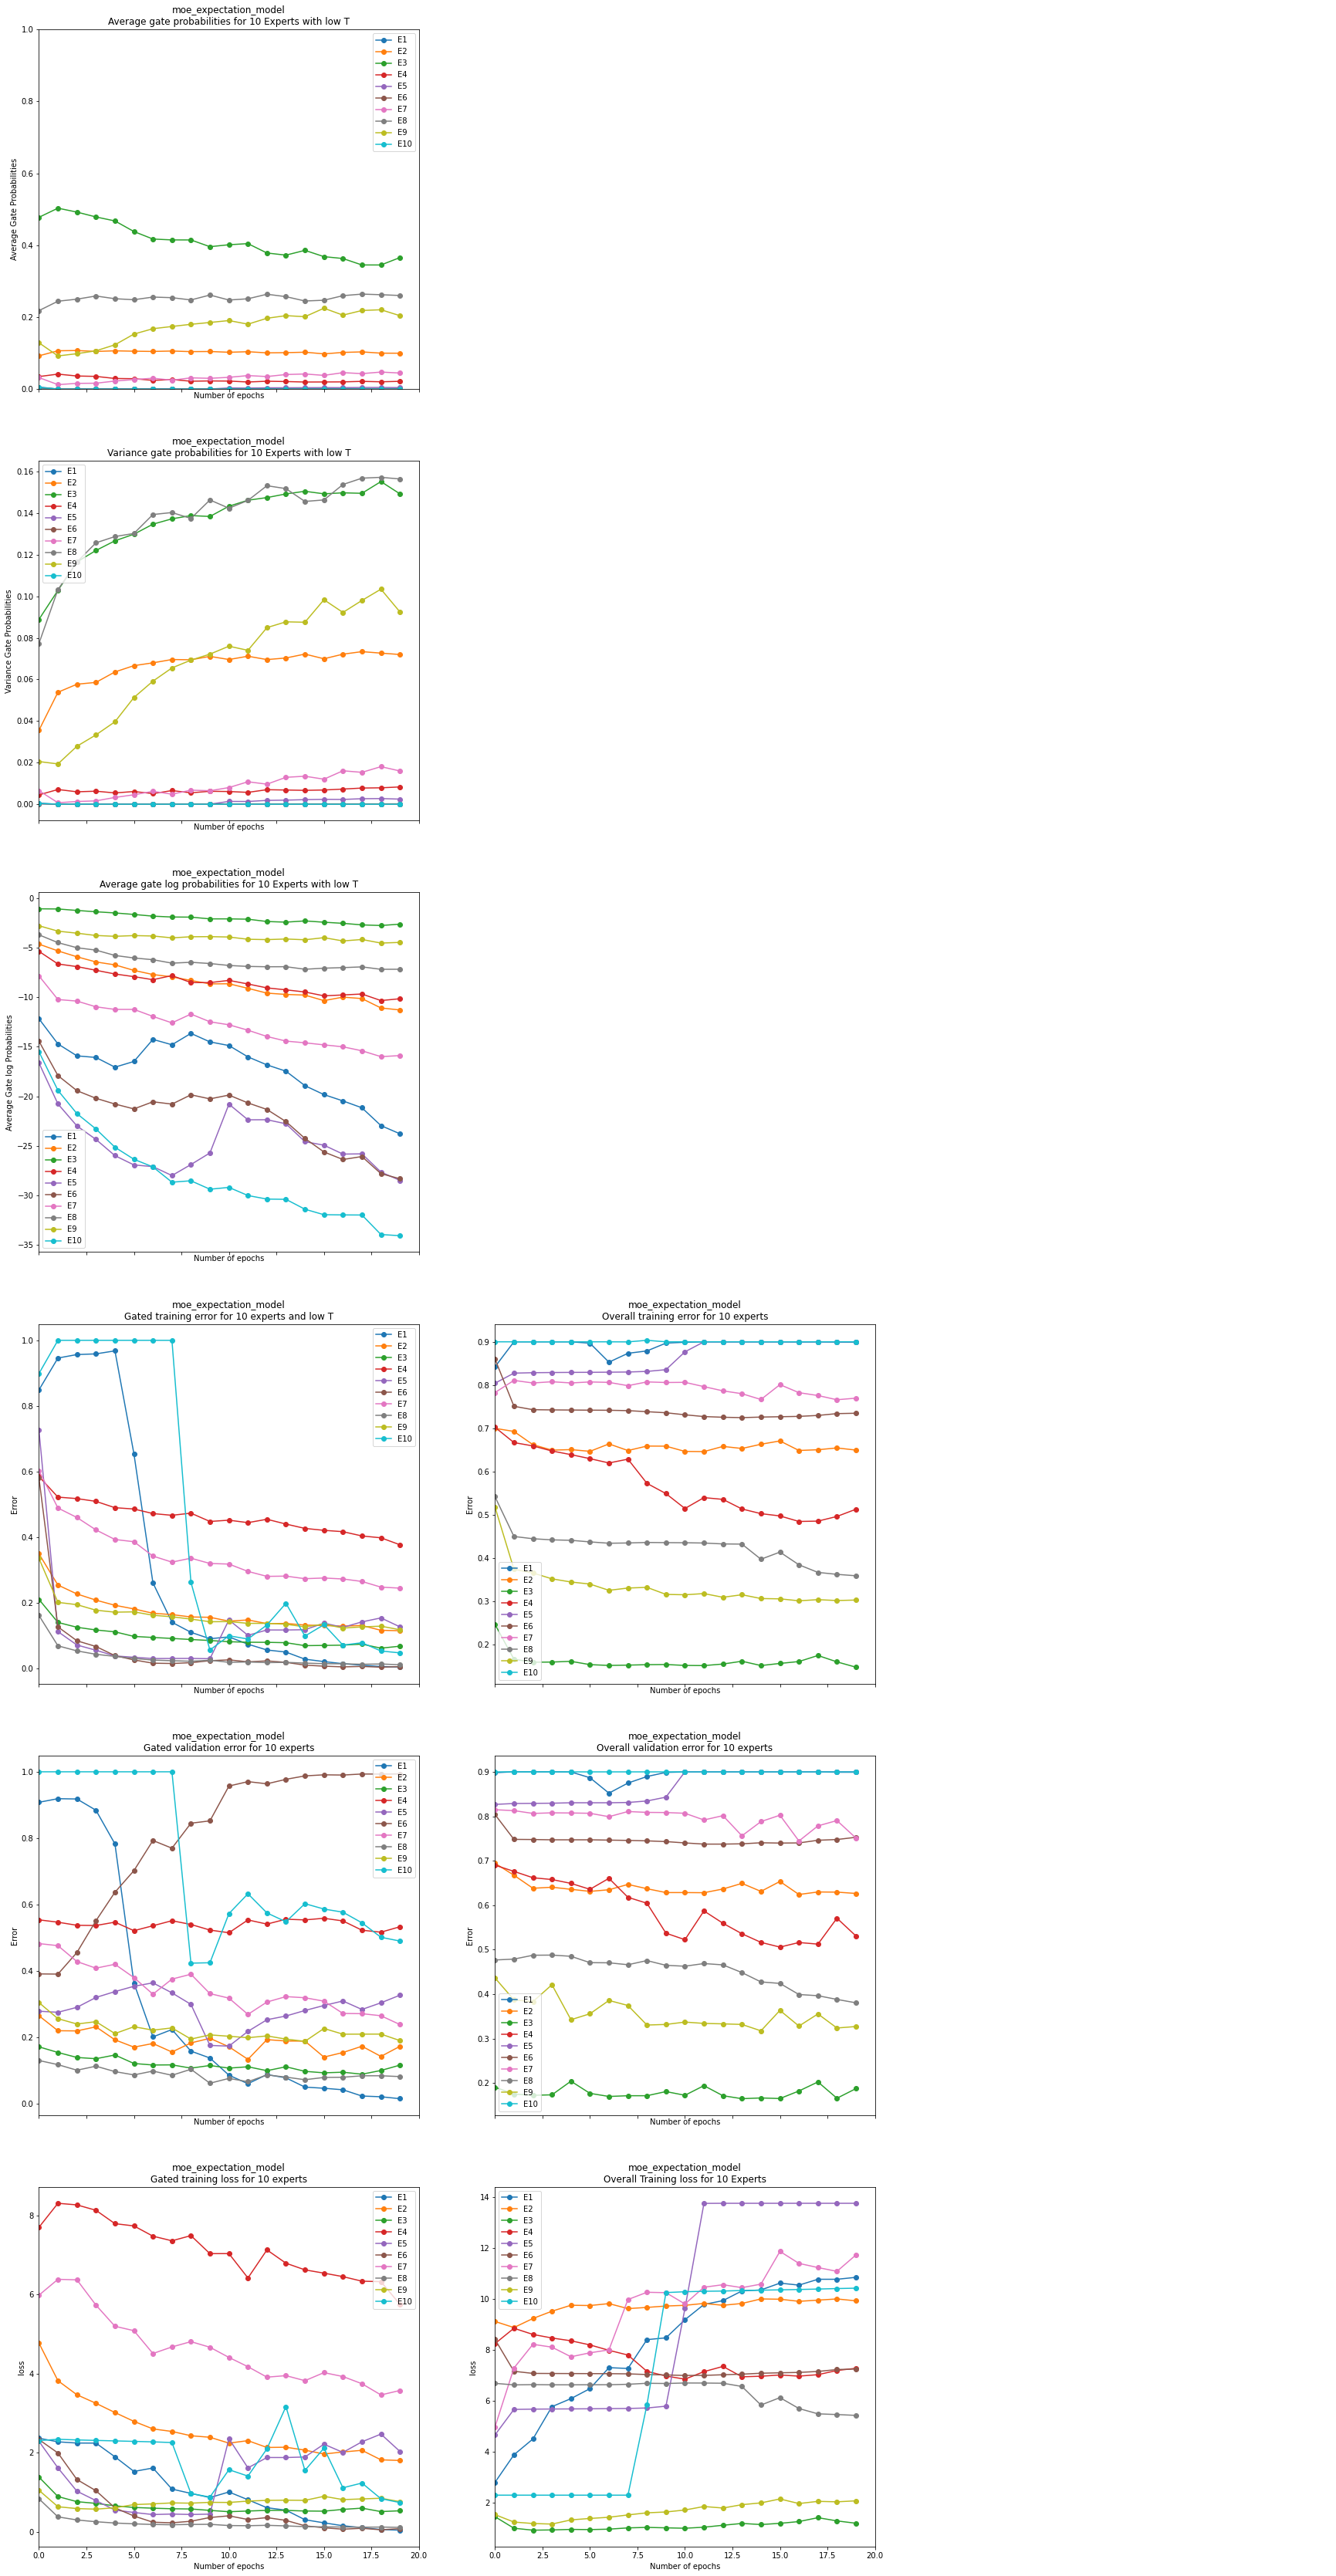

In [34]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
        plot_file = generate_plot_file(dataset,'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
        print('model: ', plot_file)
        models = torch.load(os.path.join(model_path, plot_file))

        fig,ax = plt.subplots(6, 3, sharex=True, sharey=False, figsize=(30,60))

        for m_key, m_val in models.items():
            
            for i in range(total_experts, total_experts+1):

                history = m_val['experts'][i]['history']
                legend_labels = ['E'+str(j) for j in range(1, i+1)]

                ax[0,0].plot(range(num_epochs), history['mean_gate_probability'], marker='o')            
                ax[0,0].set_title(m_key+'\n'+'Average gate probabilities for ' + str(i) + ' Experts with low T')
                ax[0,0].legend(legend_labels)
                ax[0,0].set_xlabel('Number of epochs')
                ax[0,0].set_xlim(0, num_epochs)
                ax[0,0].set_ylim(0, 1)
                ax[0,0].set_ylabel('Average Gate Probabilities')

                if T>1:
                    ax[0,1].plot(range(num_epochs), history['mean_gate_probability_T'], marker='o')
                    ax[0,1].set_title(m_key+'\n'+'Average gate probabilities for ' + str(i) + ' Experts with high T = '+str(T))
                    ax[0,1].legend(legend_labels)
                    ax[0,1].set_xlabel('Number of epochs')
                    ax[0,1].set_xlim(0, num_epochs)
                    ax[0,1].set_ylim(0, 1)
                    ax[0,1].set_ylabel('Average Gate Probabilities')
                else:
                    ax[0,1].axis('off')
                ax[0,2].axis('off')
                  
                ax[1,0].plot(range(num_epochs), history['var_gate_probability'], marker='o')            
                ax[1,0].set_title(m_key+'\n'+'Variance gate probabilities for ' + str(i) + ' Experts with low T')
                ax[1,0].legend(legend_labels)
                ax[1,0].set_xlabel('Number of epochs')
                ax[1,0].set_xlim(0, num_epochs)
                ax[1,0].set_ylabel('Variance Gate Probabilities')
                
                if T> 1:
                    ax[1,1].plot(range(num_epochs), history['var_gate_probability_T'], marker='o')
                    ax[1,1].set_title(m_key+'\n'+'Variance gate probabilities for ' + str(i) + ' Experts with high T = '+str(T))
                    ax[1,1].legend(legend_labels)
                    ax[1,1].set_xlabel('Number of epochs')
                    ax[1,1].set_xlim(0, num_epochs)
                    ax[1,1].set_ylabel('Variance Gate Probabilities')
                else:
                    ax[1,1].axis('off')                   
                ax[1,2].axis('off')
                
                ax[2,0].plot(range(num_epochs), history['mean_gate_log_probability'], marker='o')            
                ax[2,0].set_title(m_key+'\n'+'Average gate log probabilities for ' + str(i) + ' Experts with low T')
                ax[2,0].legend(legend_labels)
                ax[2,0].set_xlabel('Number of epochs')
                ax[2,0].set_xlim(0, num_epochs)
                ax[2,0].set_ylabel('Average Gate log Probabilities')

                if T>1:
                    ax[2,1].plot(range(num_epochs), history['mean_gate_log_probability_T'], marker='o')
                    ax[2,1].set_title(m_key+'\n'+'Average gate log probabilities for ' + str(i) + ' Experts with high T = '+str(T))
                    ax[2,1].legend(legend_labels)
                    ax[2,1].set_xlabel('Number of epochs')
                    ax[2,1].set_xlim(0, num_epochs)
                    ax[2,1].set_ylabel('Average Gate log Probabilities')
                else:
                    ax[2,1].axis('off')
                ax[2,2].axis('off')
                                   

                ax[3,0].plot(range(num_epochs), 1-np.asarray(history['expert_sample_accuracy']), marker='o')

                ax[3,0].set_title(m_key+'\n'+'Gated training error for ' + str(i) + ' experts and low T')
                ax[3,0].legend(legend_labels)
                ax[3,0].set_xlabel('Number of epochs')
                ax[3,0].set_xlim(0, num_epochs)
                ax[3,0].set_ylabel('Error')

                if T > 1:
                    ax[3,1].plot(range(num_epochs), 1-np.asarray(history['expert_sample_accuracy_T']), marker='o')
                    ax[3,1].set_title(m_key+'\n'+'Gated training error for ' + str(i) + ' experts and high T = '+str(T))
                    ax[3,1].legend(legend_labels)
                    ax[3,1].set_xlabel('Number of epochs')
                    ax[3,1].set_xlim(0, num_epochs)
                    ax[3,1].set_ylabel('Error')
                    
                    ax[3,2].plot(range(num_epochs), 1-np.asarray(history['expert_accuracy']), marker='o')

                    ax[3,2].set_title(m_key+'\n'+'Overall Training error for ' + str(i) + ' Experts')
                    ax[3,2].legend(legend_labels)
                    ax[3,2].set_xlabel('Number of epochs')
                    ax[3,2].set_xlim(0, num_epochs)
                    ax[3,2].set_ylabel('Error')
                else:
                    ax[3,1].plot(range(num_epochs), 1-np.asarray(history['expert_accuracy']), marker='o')

                    ax[3,1].set_title(m_key+'\n'+'Overall training error for ' + str(i) + ' experts')
                    ax[3,1].legend(legend_labels)
                    ax[3,1].set_xlabel('Number of epochs')
                    ax[3,1].set_xlim(0, num_epochs)
                    ax[3,1].set_ylabel('Error')
                    
                    ax[3,2].axis('off')
                    
    
                ax[4,0].plot(range(len(history['expert_sample_val_accuracy'])), 1-np.asarray(history['expert_sample_val_accuracy']), marker='o')
                ax[4,0].set_title(m_key+'\n'+'Gated validation error for ' + str(i) + ' experts')
                ax[4,0].legend(legend_labels)
                ax[4,0].set_xlabel('Number of epochs')
                ax[4,0].set_xlim(0, num_epochs)
                ax[4,0].set_ylabel('Error')
                
                ax[4,1].plot(range(len(history['expert_val_accuracy'])), 1-np.asarray(history['expert_val_accuracy']), marker='o')

                ax[4,1].set_title(m_key+'\n'+'Overall validation error for ' + str(i) + ' experts')
                ax[4,1].legend(legend_labels)
                ax[4,1].set_xlabel('Number of epochs')
                ax[4,1].set_xlim(0, num_epochs)
                ax[4,1].set_ylabel('Error')


                ax[4,2].axis('off')
                
                ax[5,0].plot(range(num_epochs), history['expert_sample_loss'], marker='o')

                ax[5,0].set_title(m_key+'\n'+'Gated training loss for ' + str(i) + ' experts')
                ax[5,0].legend(legend_labels)
                ax[5,0].set_xlabel('Number of epochs')
                ax[5,0].set_xlim(0, num_epochs)
                ax[5,0].set_ylabel('loss')


                if T > 1:
                    ax[5,1].plot(range(num_epochs), history['expert_sample_loss_T'], marker='o')

                    ax[5,1].set_title(m_key+'\n'+'Gated training loss for ' + str(i) + ' experts and high T = '+str(T))
                    ax[5,1].legend(legend_labels)
                    ax[5,1].set_xlabel('Number of epochs')
                    ax[5,1].set_xlim(0, num_epochs)
                    ax[5,1].set_ylabel('loss')
                    
                    ax[5,2].plot(range(num_epochs), history['expert_loss'], marker='o')

                    ax[5,2].set_title(m_key+'\n'+'Overall training loss for ' + str(i) + ' Experts')
                    ax[5,2].legend(legend_labels)
                    ax[5,2].set_xlabel('Number of epochs')
                    ax[5,2].set_xlim(0, num_epochs)
                    ax[5,2].set_ylabel('loss')

                else:               
                    ax[5,1].plot(range(num_epochs), history['expert_loss'], marker='o')

                    ax[5,1].set_title(m_key+'\n'+'Overall Training loss for ' + str(i) + ' Experts')
                    ax[5,1].legend(legend_labels)
                    ax[5,1].set_xlabel('Number of epochs')
                    ax[5,1].set_xlim(0, num_epochs)
                    ax[5,1].set_ylabel('loss')
                    
                    ax[5,2].axis('off')
                
                image_file = generate_plot_file(dataset+'_'+m_key,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
                plt.savefig(os.path.join(fig_path, 'dashboard_'+image_file))
                plt.show()


model:  fmnist_mnist_10000_3x3_T_1_10_10_model.pt


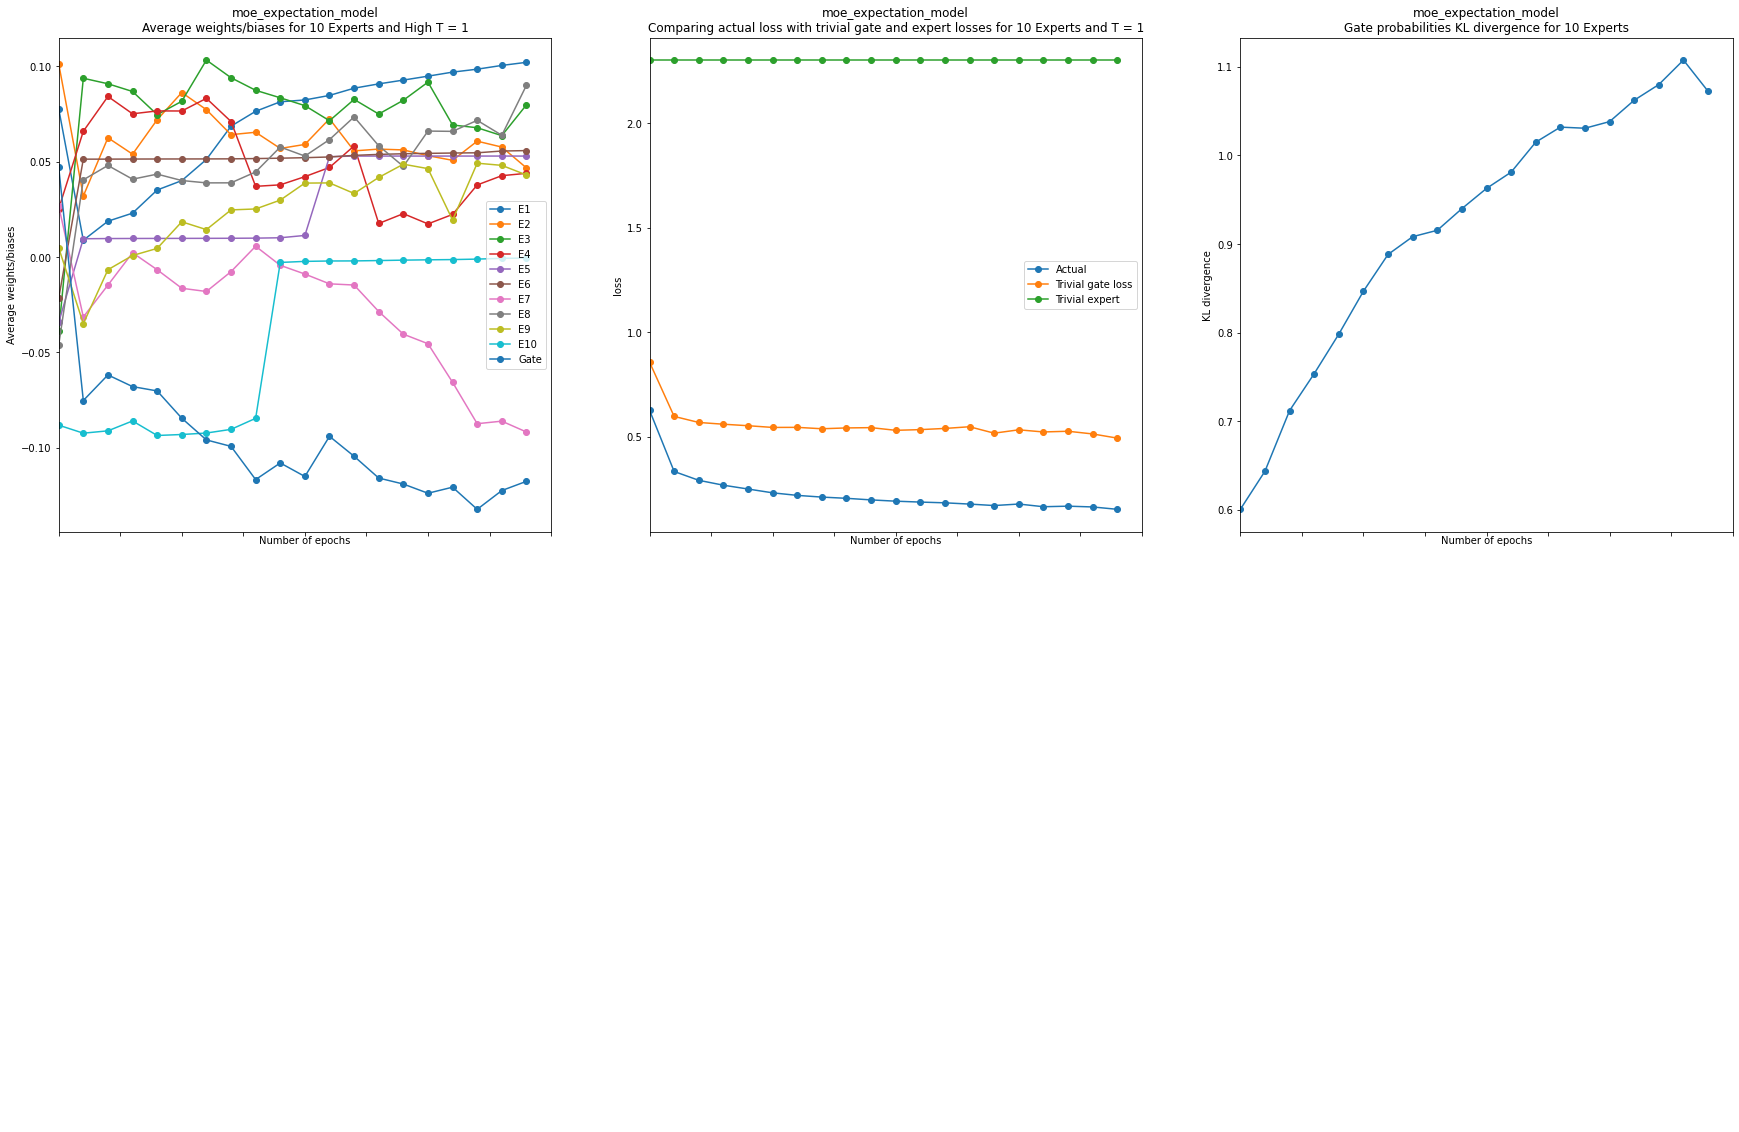

In [35]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
    plot_file = generate_plot_file(dataset,'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    print('model: ', plot_file)
    models = torch.load(os.path.join(model_path, plot_file))

    fig,ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(30,20))
    
    for m_key, m_val in models.items():
               
        for i in range(total_experts, total_experts+1):

            legend_labels = ['E'+str(j) for j in range(1, i+1)]
            
            history = m_val['experts'][i]['history']
            
            ax[0,0].plot(range(num_epochs), history['per_exp_avg_wts'], marker='o')
            ax[0,0].plot(range(num_epochs), history['gate_avg_wts'], marker='o')
            
            ax[0,0].set_title(m_key+'\n'+'Average weights/biases for ' + str(i) + ' Experts and High T = ' + str(T))
            ax[0,0].legend(legend_labels + ['Gate'])
            ax[0,0].set_xlabel('Number of epochs')
            ax[0,0].set_xlim(0, num_epochs)
            ax[0,0].set_ylabel('Average weights/biases')
            
                        
            legend_labels = ['Actual', 'Trivial gate loss', 'Trivial expert']

            ax[0,1].plot(range(num_epochs), history['loss'], marker='o')
            ax[0,1].plot(range(num_epochs), history['baseline_losses'], marker='o')

            ax[0,1].set_title(m_key+'\n'+'Comparing actual loss with trivial gate and expert losses for ' + str(i) + ' Experts and T = '+str(T))
            ax[0,1].legend(legend_labels)
            ax[0,1].set_xlabel('Number of epochs')
            ax[0,1].set_xlim(0, num_epochs)

            ax[0,1].set_ylabel('loss')
            
            ax[0,2].plot(range(num_epochs), history['kl_div_gate'], marker='o')

            ax[0,2].set_title(m_key+'\n'+'Gate probabilities KL divergence for ' + str(i) + ' Experts')
            ax[0,2].set_xlabel('Number of epochs')
            ax[0,2].set_xlim(0, num_epochs)
            ax[0,2].set_ylabel('KL divergence')

            if T>1:
                ax[1,0].plot(range(num_epochs), history['kl_div_gate_T'], marker='o')
                ax[1,0].set_title(m_key+'\n'+'Gate probabilities KL divergence for ' + str(i) + ' Experts and High T = '+str(T))
                ax[1,0].set_xlabel('Number of epochs')
                ax[1,0].set_xlim(0, num_epochs)
                ax[1,0].set_ylabel('KL divergence')
            else:
                ax[1,0].axis('off')
            ax[1,1].axis('off')
            ax[1,2].axis('off')
            
            image_file = generate_plot_file(dataset+'_'+m_key,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
            plt.savefig(os.path.join(fig_path, 'dashboard_misc_'+image_file))
            plt.show()
            

In [40]:
def transfer_learning(model, old_total_experts, new_total_experts, experts_transfer,gate_transfer, old_num_classes, new_num_classes):
    old_gate_model = model.gate
    if gate_transfer:
        new_gate_model = gate_layers(old_total_experts)    

        new_gate_model.load_state_dict(old_gate_model.state_dict())
        out_state = old_gate_model.out.state_dict()
        if new_total_experts-old_total_experts > 0:
            new_gate_model.out = nn.Linear(in_features=10, out_features=new_total_experts)
            w_padding = torch.zeros(new_total_experts-old_total_experts,10)
            b_padding = torch.zeros(new_total_experts-old_total_experts)
            out_state['weight'] = torch.cat((out_state['weight'],w_padding),0)
            out_state['bias'] = torch.cat((out_state['bias'],b_padding))
        new_gate_model.out.load_state_dict(out_state)
        for param in new_gate_model.parameters():
                    param.requires_grad = False
    else:
        new_gate_model = gate_layers(new_total_experts)    
                
    if experts_transfer:
        new_expert_models = experts(new_total_experts, old_num_classes)
        old_expert_models = model.experts
        for i, expert in enumerate(new_expert_models):
            if i < old_total_experts:
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())

                if new_num_classes - old_num_classes > 0:
                    expert.out = nn.Linear(in_features=10, out_features=new_num_classes)
                    out_state = old_expert.out.state_dict()
                    w_padding = torch.zeros(new_num_classes-old_num_classes,10)
                    b_padding = torch.zeros(new_num_classes-old_num_classes)
                    out_state['weight'] = torch.cat((out_state['weight'],w_padding),0)
                    out_state['bias'] = torch.cat((out_state['bias'],b_padding))
                    expert.out.load_state_dict(out_state)
                for param in expert.parameters():
                    param.requires_grad = False
            else:
                expert.out = nn.Linear(in_features=10, out_features=new_num_classes)
    else:
        new_expert_models = experts(new_total_experts, new_num_classes)


    return new_gate_model, new_expert_models

In [41]:
pretrained_moe_expectation_model = models['moe_expectation_model']['experts'][total_experts]['model']
new_total_experts = 10
old_total_experts = total_experts
old_num_classes = num_classes
new_num_classes = 10
new_gate_model, new_expert_models = transfer_learning(pretrained_moe_expectation_model, old_total_experts, 
                                                     new_total_experts, True, False, 
                                                      old_num_classes, new_num_classes)

In [42]:
pretrained_moe_expectation_model.gate = new_gate_model
pretrained_moe_expectation_model.experts = new_expert_models
pretrained_moe_expectation_model.num_experts = new_total_experts
pretrained_moe_expectation_model.num_classes = new_num_classes

In [43]:
new_trainloader = torch.utils.data.DataLoader(trainset, 
                                              batch_size=batchsize,
                                              shuffle=True, num_workers=1)
new_testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=test_size,
                                             shuffle=True, num_workers=1)

In [44]:
optimizer_new = optim.RMSprop(pretrained_moe_expectation_model.parameters(),
                              lr=0.001, momentum=0.9)

hist_new = pretrained_moe_expectation_model.train(new_trainloader, new_testloader, 
                                 cross_entropy_loss, optimizer_new,
                                 accuracy=accuracy, epochs=30)
print('Finished Training')

epoch 0 training loss 1.19 , training accuracy 0.61 , test accuracy 0.75
epoch 1 training loss 0.49 , training accuracy 0.82 , test accuracy 0.80
epoch 2 training loss 0.40 , training accuracy 0.87 , test accuracy 0.85
epoch 3 training loss 0.33 , training accuracy 0.90 , test accuracy 0.86
epoch 4 training loss 0.31 , training accuracy 0.91 , test accuracy 0.86
epoch 5 training loss 0.30 , training accuracy 0.91 , test accuracy 0.87
epoch 6 training loss 0.29 , training accuracy 0.91 , test accuracy 0.87
epoch 7 training loss 0.29 , training accuracy 0.91 , test accuracy 0.87
epoch 8 training loss 0.28 , training accuracy 0.91 , test accuracy 0.88
epoch 9 training loss 0.27 , training accuracy 0.91 , test accuracy 0.88
epoch 10 training loss 0.27 , training accuracy 0.92 , test accuracy 0.85
epoch 11 training loss 0.28 , training accuracy 0.91 , test accuracy 0.88
epoch 12 training loss 0.27 , training accuracy 0.92 , test accuracy 0.88
epoch 13 training loss 0.26 , training accuracy 

In [45]:
plot_file = generate_plot_file('fmnist_transfer', 'T_'+str(T)+'_'+str(new_num_classes)+'_'+str(new_total_experts)+'_model.pt')
torch.save(pretrained_moe_expectation_model,open(os.path.join('results/review', plot_file),'wb'))

In [46]:
models = {'moe_expectation_model':{'experts':{new_total_experts:{'model':pretrained_moe_expectation_model, 'history':hist_new}}}}

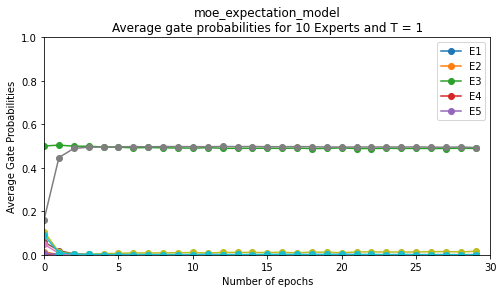

In [48]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
    
    for m_key, m_val in models.items():
        for i in range(new_total_experts, new_total_experts+1):
            history = m_val['experts'][i]['history']
            plt.plot(range(len(history['gate_probability'])), history['gate_probability'], marker='o')
        legend_labels = ['E'+str(i) for i in range(1, total_experts+1)]
        plt.title(m_key+'\n'+'Average gate probabilities for ' + str(i) + ' Experts and T = '+str(T))
        plt.legend(legend_labels)
        plt.xlabel('Number of epochs')
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1)
        plt.ylabel('Average Gate Probabilities')
        image_file = generate_plot_file(dataset+'_'+m_key,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
        plt.savefig(os.path.join('figures/review', 'gate_prob_'+image_file))
        plt.show()


In [36]:
def get_labels(p):
    pred_labels = torch.argmax(p, dim=1)
    return pred_labels

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def predict(dataloader, model):
        
        pred_labels = []
        true_labels = []
        for i, data in enumerate(dataloader):
            inputs, labels = data
            true_labels.append(labels)
            pred_labels.append(torch.argmax(model(inputs), dim=1))
            
        return torch.stack(true_labels), torch.stack(pred_labels)

In [38]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=len(trainset),
                                          shuffle=False, num_workers=1)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=len(testset),
                                         shuffle=False, num_workers=1)
classes = classes_fmnist[0:5]+classes_mnist[5:]

In [63]:
fmnist_trainloader = torch.utils.data.DataLoader(Subset(fmnist_trainset, fmnist_indices_train), 
                                          batch_size=len(fmnist_trainset),
                                          shuffle=False, num_workers=1)

fmnist_testloader = torch.utils.data.DataLoader(Subset(fmnist_testset, fmnist_indices_test),
                                         batch_size=len(fmnist_testset),
                                         shuffle=False, num_workers=1)
print(len(fmnist_trainloader.dataset))
print(len(fmnist_testloader.dataset))

5000
1500


In [77]:
trainloader = fmnist_trainloader
testloader = fmnist_testloader
classes = classes_fmnist[0:5]
plot_file = generate_plot_file('fmnist_transfer', 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
models = torch.load(os.path.join('results/review', plot_file))

X: torch.Size([10000, 1, 28, 28])
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
PCA: (10000, 50)
y: torch.Size([10000])
TSNE: (10000, 2)


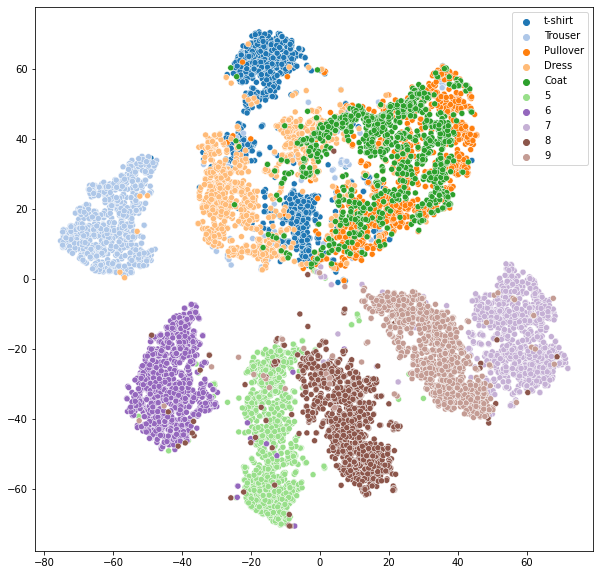

In [35]:
for X, y in trainloader:
    X_pca_new, X_tsne_new = pca_tsne_plot(X, y, classes, 'fmnist_transfer', len(trainloader.dataset))

In [36]:
X_pca = X_pca_new
X_tsne = X_tsne_new

In [45]:
pickle.dump([X_pca, X_tsne], open(os.path.join(model_path, dataset+'_pca_tsne.pkl'), 'wb'))

In [40]:
X_pca, X_tsne = pickle.load(open(os.path.join(model_path, dataset+'_pca_tsne.pkl'), 'rb'))

dict_keys(['moe_expectation_model'])
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', '5', '6', '7', '8', '9']
Number of Experts: 10
MOE accuracy tensor(0.9431)


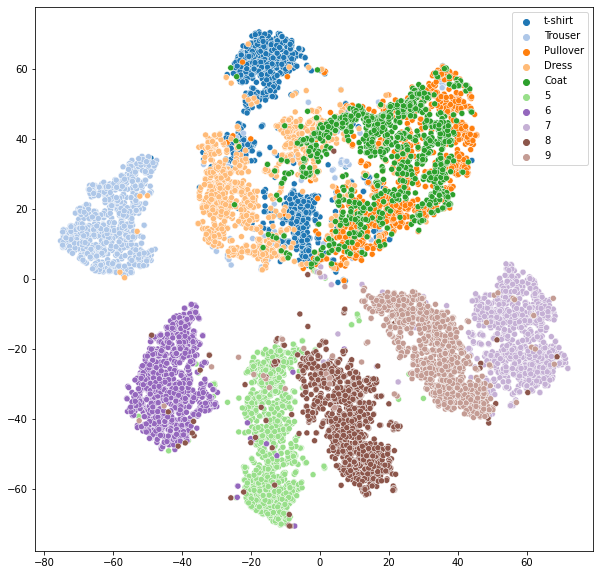

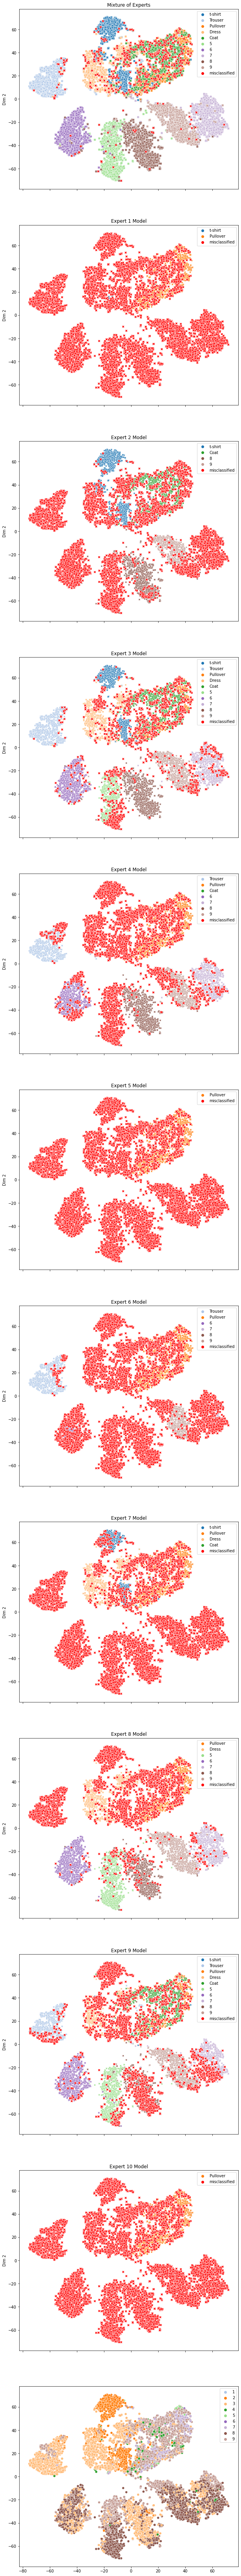

In [42]:
keys = models.keys()
print(keys)
start = 10
end = 11
class_names = classes
print(class_names)
for e in range(start, end):
    nrows = 2+e
    ncols = len(keys)
    thefigsize = (ncols*10,nrows*10)

    for X, y in trainloader:
        print('Number of Experts:', e)
        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))
        true_label_names = [class_names[i] for i in y]
        true_color = colors(y, palette[0:num_classes]) 
        sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1], 
                    hue=true_label_names,hue_order=class_names, 
                    palette=true_color, ax=ax)

        fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
        ax = ax.flatten()

        index = 0

        for m_key, m_val in models.items():

            moe_model = m_val['experts'][e]['model']
 
            pred = moe_model(X)
            print('MOE accuracy', accuracy(pred, y))
            pred_labels = get_labels(pred)
            pred_label_names = [class_names[i] for i in pred_labels]
            pred_color = colors(pred_labels, palette[0:num_classes])
            pred_classes = [class_names[i] for i in np.unique(pred_labels)]
            sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1], 
                            hue=true_label_names,hue_order=class_names, palette=true_color,
                            legend=False,ax=ax[index]) #s=50, alpha=0.6,
            sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                            hue=pred_label_names,hue_order=pred_classes, palette=pred_color,
                            marker='X',  ax=ax[index]) # s=20,alpha=1.0,
            indices = np.where((pred_labels == y) == False)[0]
            sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                            hue=['misclassified']*len(indices), palette=['r'], marker='X', ax=ax[index])

            ax[index].set_title('Mixture of Experts')
            ax[index].set_ylabel('Dim 2')
            ax[index].set_xlabel('Dim 1')

            for i in range(0, e):
                pred = moe_model.expert_outputs[:,i,:]
                pred_labels = get_labels(pred)
                pred_label_names = [class_names[i] for i in pred_labels]
                pred_color = colors(pred_labels, palette[0:num_classes])
                pred_classes = [class_names[i] for i in np.unique(pred_labels)]

                sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], 
                            hue=pred_label_names, hue_order=pred_classes, palette=pred_color, 
                            marker='X', s=20, alpha=1.0,
                            ax=ax[((i+1)*ncols)+index])
                
                indices = np.where((pred_labels == y) == False)[0]
                sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                                hue=['misclassified']*len(indices), palette=['r'], marker='X', ax=ax[((i+1)*ncols)+index])


                ax[((i+1)*ncols)+index].set_title('Expert '+str(i+1)+' Model')
                ax[((i+1)*ncols)+index].set_ylabel('Dim 2')
                ax[((i+1)*ncols)+index].set_xlabel('Dim 1')

            pred_gate = moe_model.gate_outputs
            pred_gate_labels = get_labels(pred_gate)+1
            pred_gate_color = colors(pred_gate_labels, palette)
        
            sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                            hue=pred_gate_labels,hue_order=np.unique(pred_gate_labels),
                            palette=pred_gate_color, ax=ax[(e+1)*ncols])       

            index += 1
    plt.savefig(os.path.join('figures/fmnist', 'fmnist_transfer_'+str(e)+'_experts.png'))
    plt.show()

dict_keys(['moe_expectation_model'])
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat']
Number of Experts: 5
MOE accuracy tensor(0.9112)


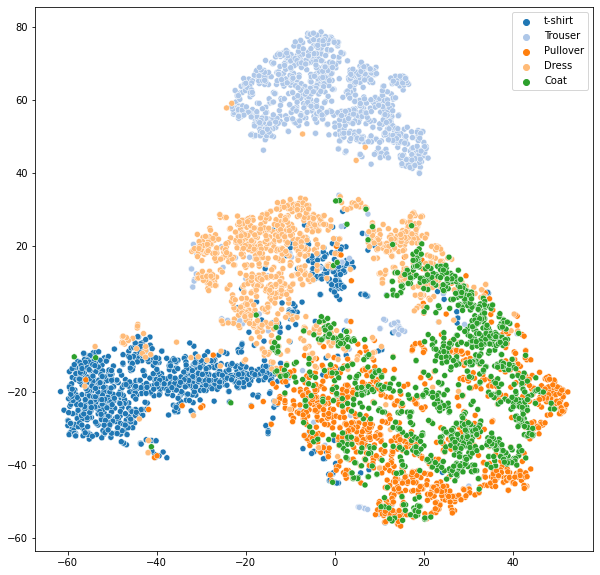

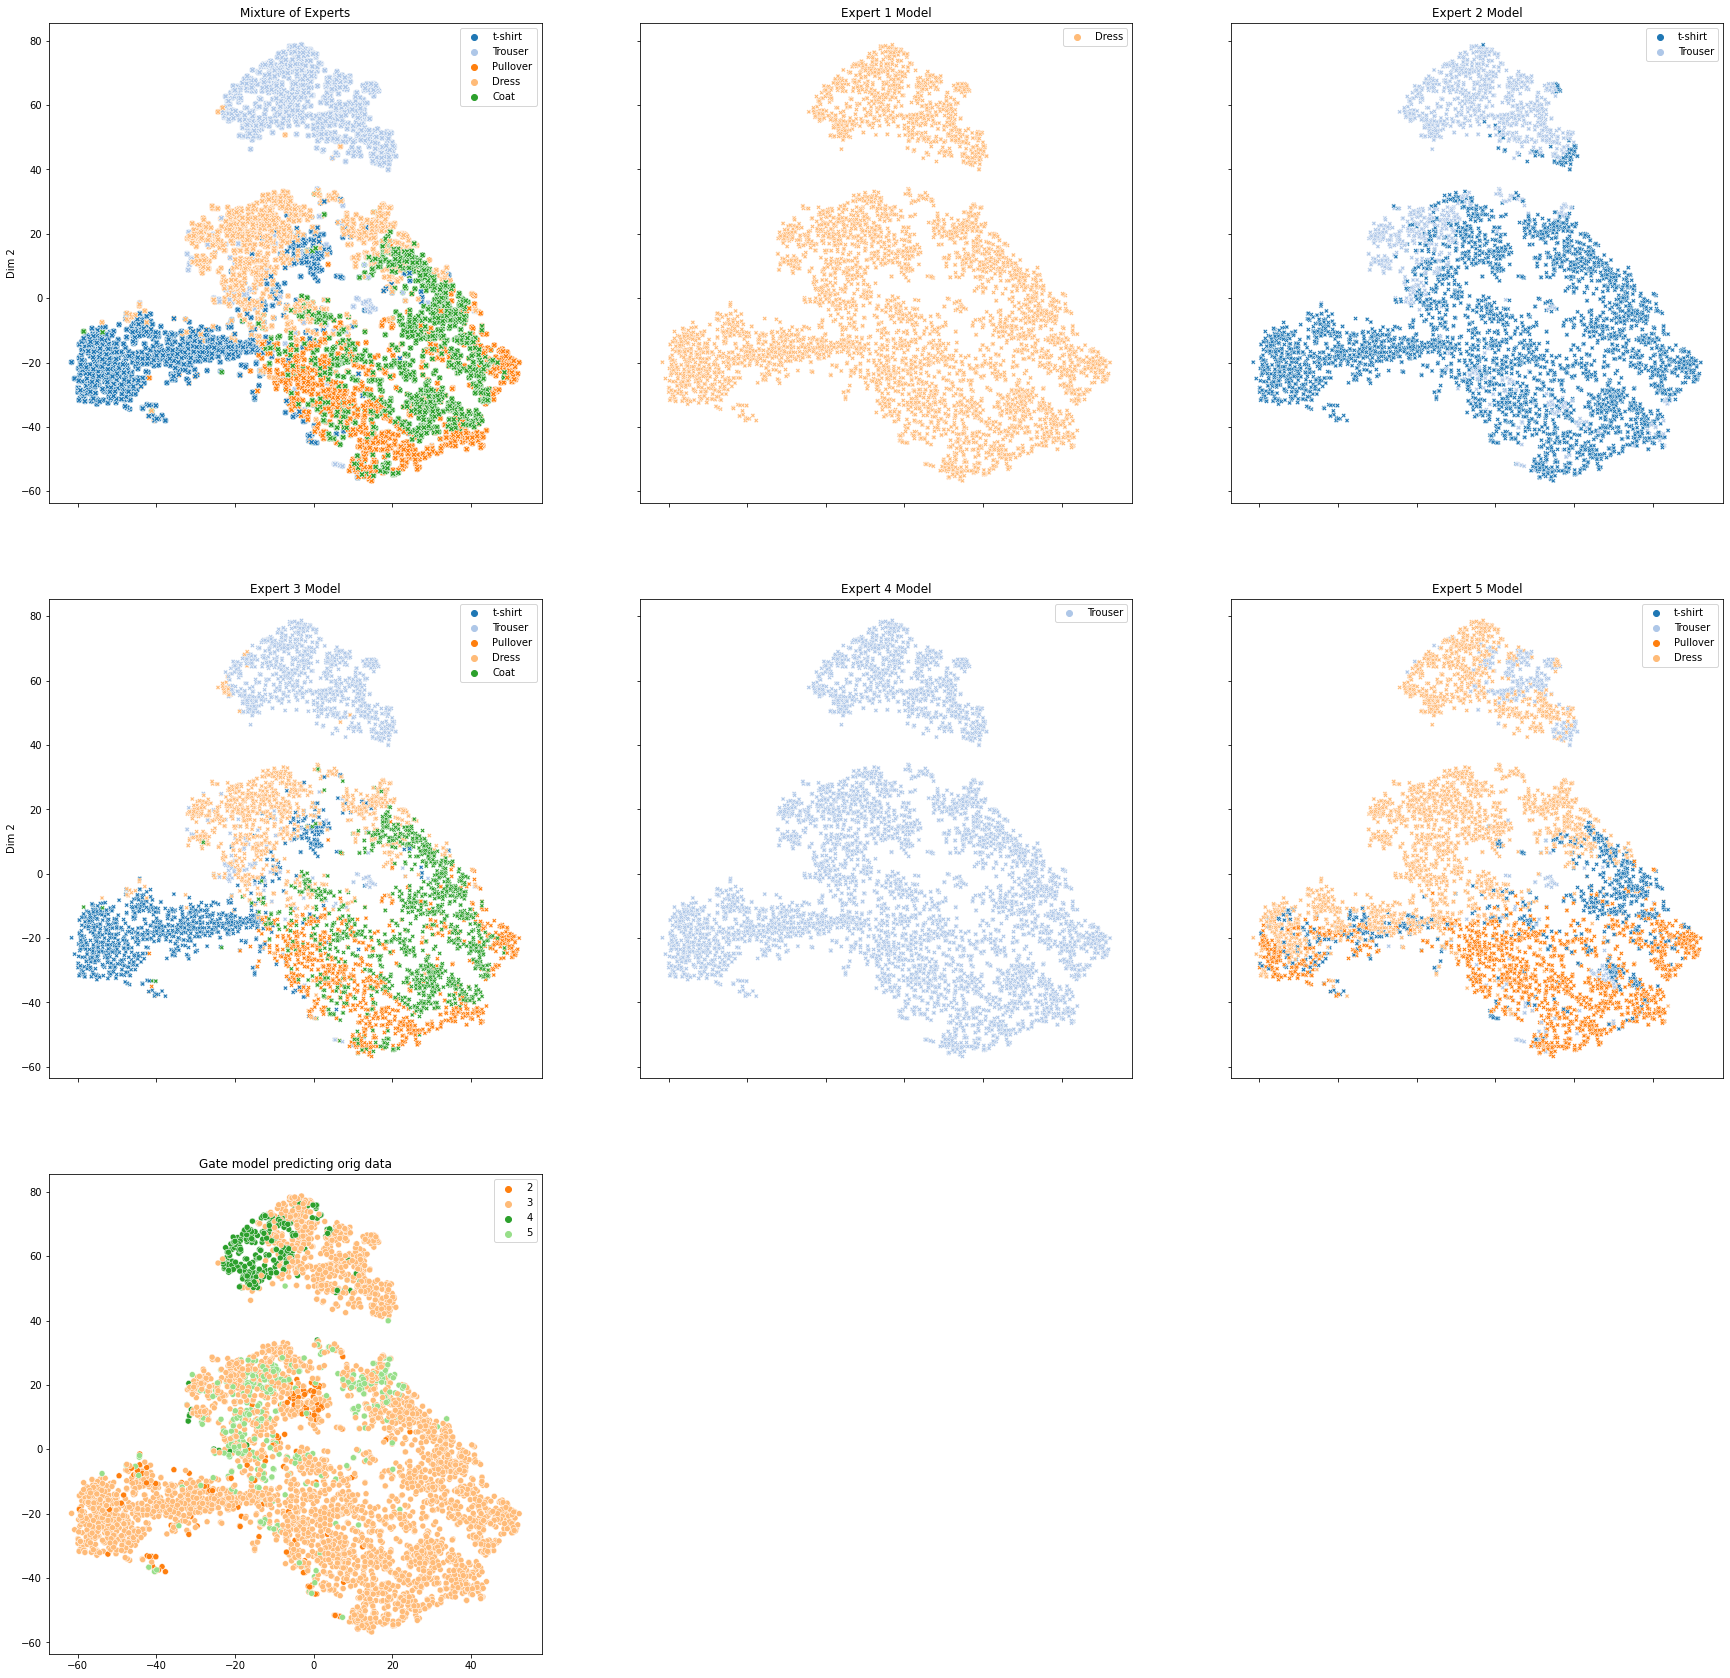

In [80]:
keys = models.keys()
print(keys)
start = 5
end = 6
class_names = classes
num_classes = 5
print(class_names)
for e in range(start, end):
    nrows = 2+e
    ncols = len(keys)
    thefigsize = (30, 3*10)

    print('Number of Experts:', e)
    fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))
    true_label_names = [class_names[i] for i in y]
    true_color = colors(y, palette[0:num_classes]) 
    sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1], 
                hue=true_label_names,hue_order=class_names, 
                palette=true_color, ax=ax)
    
    fig,ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    index = 0
    for X, y in trainloader:
        for m_key, m_val in models.items():

            moe_model = m_val['experts'][e]['model']
 
            pred = moe_model(X)
            print('MOE accuracy', accuracy(pred, y))
            pred_labels = get_labels(pred)
            pred_label_names = [class_names[i] for i in pred_labels]
            pred_color = colors(pred_labels, palette[0:num_classes])
            pred_classes = [class_names[i] for i in np.unique(pred_labels)]
            sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1], 
                            hue=true_label_names,hue_order=class_names, palette=true_color,
                            legend=False,ax=ax[index]) #s=50, alpha=0.6,
            sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                            hue=pred_label_names,hue_order=pred_classes, palette=pred_color,
                            marker='X',  ax=ax[index]) # s=20,alpha=1.0,
            ax[index].set_title('Mixture of Experts')
            ax[index].set_ylabel('Dim 2')
            ax[index].set_xlabel('Dim 1')

            for i in range(0, e):
                index+=1
                pred = moe_model.expert_outputs[:,i,:]
                pred_labels = get_labels(pred)
                pred_label_names = [class_names[i] for i in pred_labels]
                pred_color = colors(pred_labels, palette[0:num_classes])
                pred_classes = [class_names[i] for i in np.unique(pred_labels)]

#                 sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1], 
#                             hue=true_label_names, hue_order=class_names, palette=true_color,
#                             legend=False, s=50, alpha=0.6,
#                             ax=ax[((i+1)*ncols)+index])

                sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], 
                            hue=pred_label_names, hue_order=pred_classes, palette=pred_color, 
                            marker='X', s=20, alpha=1.0,
                            ax=ax[index])

                ax[index].set_title('Expert '+str(i+1)+' Model')
                ax[index].set_ylabel('Dim 2')
                ax[index].set_xlabel('Dim 1')
            
            index+=1
            pred_gate = moe_model.gate_outputs
            pred_gate_labels = get_labels(pred_gate)+1
            pred_gate_color = colors(pred_gate_labels, palette)
        
            sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                            hue=pred_gate_labels,hue_order=np.unique(pred_gate_labels),
                            palette=pred_gate_color, ax=ax[index])   
            ax[index].set_title('Gate model predicting orig data')
            ax[7].set_axis_off()
            ax[8].set_axis_off()
            index += 1
    plt.savefig(os.path.join('figures/review', 'fmnist_transfer_'+str(e)+'_experts.png'))
    plt.show()

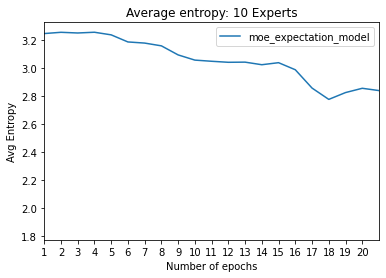

In [194]:
for i in range(start, end):
    
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['entropy'])), history['entropy'])
        legend_labels.append(m_key)
    plt.title('Average entropy: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Avg Entropy')
    #plt.ylim(0, 1)
    plt.savefig('figures/all/entropy_'+dataset+'_'+ str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

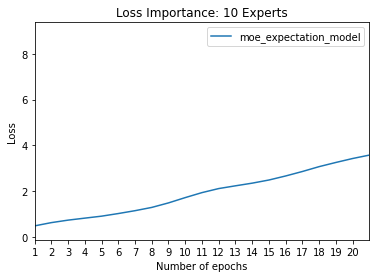

In [195]:
for i in range(start, end):
    
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['loss_importance'])), history['loss_importance'])
        legend_labels.append(m_key)
    plt.title('Loss Importance: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Loss')
#     plt.ylim(0, 1)
    plt.savefig('figures/all/loss_importance_'+dataset+'_'+ str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

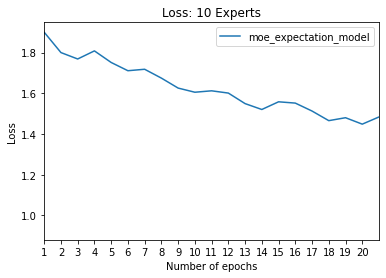

In [196]:
for i in range(start, end):
    
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['loss'])), history['loss'])
        legend_labels.append(m_key)
    plt.title('Loss: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Loss')
#     plt.ylim(0, 1)
    plt.savefig('figures/all/loss_'+dataset+'_'+ str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

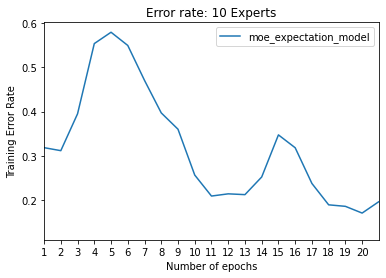

In [197]:
for i in range(start, end):
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['accuracy'])), 1-np.asarray(history['accuracy']))
        legend_labels.append(m_key)
    plt.title('Error rate: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Training Error Rate')
#     plt.ylim(0, 1)
    plt.savefig('figures/all/accuracy_'+dataset+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

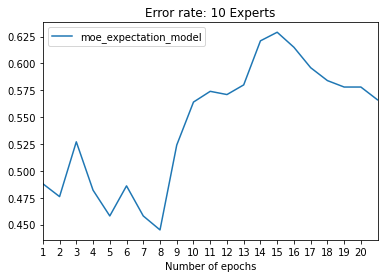

In [198]:
for i in range(start, end):
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['val_accuracy'])), 1-np.asarray(history['val_accuracy']))
        legend_labels.append(m_key)
    plt.title('Error rate: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.savefig('figures/all/val_accuracy_'+dataset+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

In [73]:
num_classes = 10

In [38]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [39]:
#Expert network
class single_model_layers(nn.Module):
    def __init__(self, output):
        super(single_model_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        
#         self.fc1 = nn.Linear(in_features=1*12*12, out_features=8)
#         self.fc2 = nn.Linear(in_features=8, out_features=4)

        self.out = nn.Linear(in_features=1*13*13, out_features=output)

    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 1*13*13)
#         t = self.fc1(t)
#         t = F.relu(t)

        # fc2
#         t = self.fc2(t)
#         t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t, dim=1)
        return t


In [40]:
single_model = single_model_layers(num_classes)

In [41]:
single_model_optimizer = optim.RMSprop(single_model.parameters(),
                                      lr=0.001, momentum=0.9)

In [77]:
train_size = 10000
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,list(range(0,train_size))), 
                                          batch_size=batchsize,
                                          shuffle=False, num_workers=1)
test_size = 3000
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=False, num_workers=1)

In [81]:
train_size = len(indices_train)
test_size = len(indices_test)
num_classes = 5

In [83]:
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(trainset,indices_train), list(range(0,train_size))), 
                                          batch_size=batchsize,
                                          shuffle=False, num_workers=1)
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(testset,indices_test),list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=False, num_workers=1)

In [43]:
single_model_history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
num_epochs = 20
for epoch in range(0, num_epochs):
    running_loss = 0.0
    training_accuracy = 0.0
    test_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        X, y = data

        # zero the parameter gradients
        single_model_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = single_model(X)
        loss = cross_entropy_loss(outputs, y)
        loss.backward()
        single_model_optimizer.step()
        
        running_loss += loss.item()
        training_accuracy += accuracy(outputs, y)
        
    for j, test_data in enumerate(testloader, 0):
        test_input, test_labels = test_data
        test_outputs = single_model(test_input)
        test_accuracy += accuracy(test_outputs, test_labels)
    single_model_history['loss'].append(running_loss/(i+1))
    single_model_history['accuracy'].append(training_accuracy/(i+1))
    single_model_history['val_accuracy'].append(test_accuracy/(j+1))
    print('epoch: %d loss: %.2f training accuracy: %.2f val accuracy: %.2f' %
            (epoch + 1, running_loss / (i+1), training_accuracy/(i+1), test_accuracy/(j+1)))

print('Finished Training')

epoch: 1 loss: 0.66 training accuracy: 0.79 val accuracy: 0.84
epoch: 2 loss: 0.35 training accuracy: 0.88 val accuracy: 0.87
epoch: 3 loss: 0.30 training accuracy: 0.90 val accuracy: 0.88
epoch: 4 loss: 0.29 training accuracy: 0.90 val accuracy: 0.89
epoch: 5 loss: 0.27 training accuracy: 0.91 val accuracy: 0.88
epoch: 6 loss: 0.26 training accuracy: 0.91 val accuracy: 0.89
epoch: 7 loss: 0.25 training accuracy: 0.91 val accuracy: 0.89
epoch: 8 loss: 0.24 training accuracy: 0.92 val accuracy: 0.88
epoch: 9 loss: 0.23 training accuracy: 0.92 val accuracy: 0.89
epoch: 10 loss: 0.23 training accuracy: 0.92 val accuracy: 0.89
epoch: 11 loss: 0.23 training accuracy: 0.92 val accuracy: 0.89
epoch: 12 loss: 0.23 training accuracy: 0.92 val accuracy: 0.89
epoch: 13 loss: 0.22 training accuracy: 0.92 val accuracy: 0.89
epoch: 14 loss: 0.22 training accuracy: 0.92 val accuracy: 0.89
epoch: 15 loss: 0.22 training accuracy: 0.92 val accuracy: 0.89
epoch: 16 loss: 0.21 training accuracy: 0.92 val 

In [79]:
train_size = 10000
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,list(range(0,train_size))), 
                                          batch_size=train_size,
                                          shuffle=False, num_workers=1)
test_size = 3000
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=False, num_workers=1)

NameError: name 'labels' is not defined

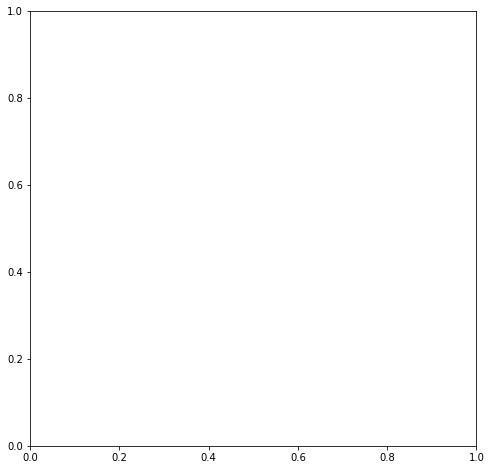

In [80]:
fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,8))
palette = sns.color_palette("Paired")+sns.color_palette('Set2')

for X, y in trainloader:
    pred = single_model(X)
    pred_color,pred_labels = labels(pred, palette)
    sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                    hue=pred_labels,palette=pred_color,legend=True, ax=ax)
    #sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette=palette, ax=ax)
    ax.set_title('Single Model')
    ax.set_ylabel('Dim 2')
    ax.set_xlabel('Dim 1')
    ax.legend(classes)